## Fake News Detection Using LSTM

### Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from wordcloud import WordCloud

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [4]:
fake=pd.read_csv('fake-real-news-dataset-main/fake-real-news-dataset-main/data/Fake.csv')

In [5]:
fake.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017

In [6]:
fake.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [7]:
fake['subject'].value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

<AxesSubplot:xlabel='subject', ylabel='count'>

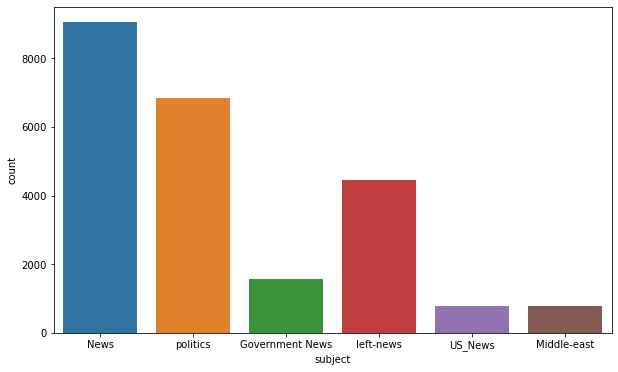

In [8]:
plt.figure(figsize=(10,6))
sns.countplot(x='subject',data=fake)

### WordCloud

In [9]:
fake['text'].tolist()

['Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! His lack of decency won t e

In [10]:
text=' '.join(fake['text'].tolist())

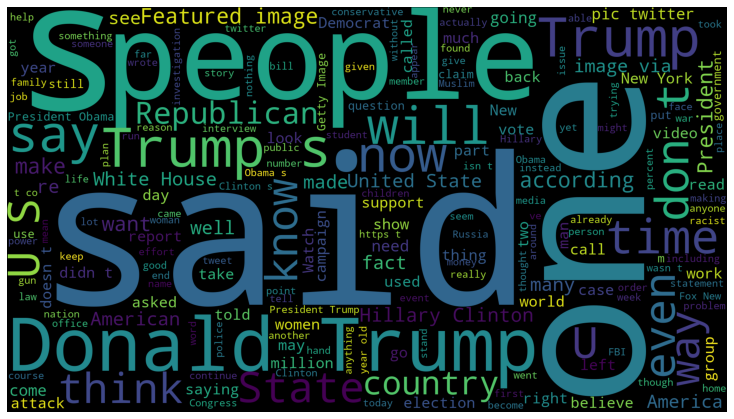

In [11]:
wordcloud=WordCloud(width=1920,height=1080).generate(text)
fig=plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### Exploring RealDataset

In [12]:
real=pd.read_csv('fake-real-news-dataset-main/fake-real-news-dataset-main/data/True.csv')

In [13]:
real.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017   
2  December 31, 2017   
3  December 30, 2017   
4  December 29, 2017

In [14]:
real['text'].tolist()

['WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-defense “discretionary” spending on programs that support educa

In [15]:
text=' '.join(real['text'].tolist())

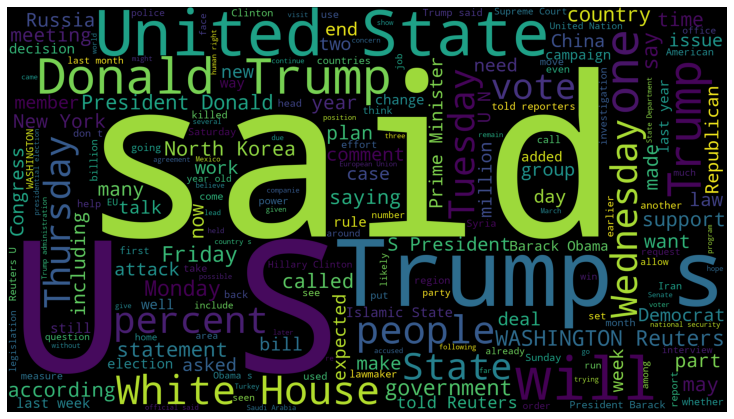

In [16]:
wordcloud=WordCloud(width=1920,height=1080).generate(text)
fig=plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [17]:
real.sample(5)

title  \
4737   Senate panel presses SEC nominee Clayton on co...   
2293   Special counsel Mueller asks White House for F...   
11960  Activist investor files Chevron proxy resoluti...   
16410  Hezbollah says U.S. sanctions aim to stir unre...   
11434  Three workers die in gas accident at Libyan oi...   

                                                    text       subject  \
4737   WASHINGTON (Reuters) - Jay Clayton, the Wall S...  politicsNews   
2293   WASHINGTON (Reuters) - Investigators working f...  politicsNews   
11960  HOUSTON (Reuters) - An activist investor in Ch...     worldnews   
16410  BEIRUT (Reuters) - A Hezbollah member of the L...     worldnews   
11434  BENGHAZI, Libya (Reuters) - Three workers, two...     worldnews   

                     date  
4737      March 23, 2017   
2293      August 5, 2017   
11960  December 18, 2017   
16410   October 26, 2017   
11434  December 24, 2017

In [18]:
unknown_publishers=[]
for index, row in enumerate(real.text.values):
    try:
        record=row.split('-',maxsplit=1)
        record[1]
        assert(len(record[0])<120)
    except:
        unknown_publishers.append(index)        

In [19]:
len(unknown_publishers)

222

In [20]:
real.iloc[8970]

title      Graphic: Supreme Court roundup
text                                     
subject                      politicsNews
date                       June 16, 2016 
Name: 8970, dtype: object

In [21]:
publisher=[]
tmp_text=[]
for index, row in enumerate(real.text.values):
    if index in unknown_publishers:
        tmp_text.append(row)
        publisher.append('Unknown')
    else:
        record=row.split('-',maxsplit=1)
        publisher.append(record[0].strip())
        tmp_text.append(record[1].strip())

In [22]:
real['publisher']=publisher
real['text']=tmp_text

In [23]:
real.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  The head of a conservative Republican faction ...  politicsNews   
1  Transgender people will be allowed for the fir...  politicsNews   
2  The special counsel investigation of links bet...  politicsNews   
3  Trump campaign adviser George Papadopoulos tol...  politicsNews   
4  President Donald Trump called on the U.S. Post...  politicsNews   

                 date                     publisher  
0  December 31, 2017           WASHINGTON (Reuters)  
1  December 29, 2017           WASHINGTON (Reuters)  
2  December 31, 2017           WASHINGTON (Reuters)  
3  December 30, 2017           WASHINGTON (Reuters)  
4  December 29, 2017   SEATTLE/WASHINGTON (Reuters)

In [24]:
real.shape

(21417, 5)

In [25]:
empty_fake_index=[index for index, text in enumerate(fake.text.tolist()) if str(text).strip()==""]

In [26]:
fake.iloc[empty_fake_index]

title text    subject  \
10923  TAKE OUR POLL: Who Do You Think President Trum...        politics   
11041  Joe Scarborough BERATES Mika Brzezinski Over “...        politics   
11190  WATCH TUCKER CARLSON Scorch Sanctuary City May...        politics   
11225  MAYOR OF SANCTUARY CITY: Trump Trying To Make ...        politics   
11236  SHOCKER: Public School Turns Computer Lab Into...        politics   
...                                                  ...  ...        ...   
21816  BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...       left-news   
21826  FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...       left-news   
21827  (VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...       left-news   
21857  (VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...       left-news   
21873  (VIDEO) HYSTERICAL SNL TAKE ON HILLARY’S ANNOU...       left-news   

               date  
10923  May 10, 2017  
11041  Apr 26, 2017  
11190   Apr 6, 2017  
11225   Apr 2, 2017  
11236   Apr 1, 2017  
...             ...  
21816  Apr 27, 2015  
21826  Apr 25, 2015  
21827  Apr 25, 2015  
21857  Apr 14, 2015  
21873  Apr 12, 2015  

[630 rows x 4 columns]

In [27]:
real['title'] + " " + real['text']

0        As U.S. budget fight looms, Republicans flip t...
1        U.S. military to accept transgender recruits o...
2        Senior U.S. Republican senator: 'Let Mr. Muell...
3        FBI Russia probe helped by Australian diplomat...
4        Trump wants Postal Service to charge 'much mor...
                               ...                        
21412    'Fully committed' NATO backs new U.S. approach...
21413    LexisNexis withdrew two products from Chinese ...
21414    Minsk cultural hub becomes haven from authorit...
21415    Vatican upbeat on possibility of Pope Francis ...
21416    Indonesia to buy $1.14 billion worth of Russia...
Length: 21417, dtype: object

In [28]:
fake['title']+ " " + fake['text']

0         Donald Trump Sends Out Embarrassing New Year’...
1         Drunk Bragging Trump Staffer Started Russian ...
2         Sheriff David Clarke Becomes An Internet Joke...
3         Trump Is So Obsessed He Even Has Obama’s Name...
4         Pope Francis Just Called Out Donald Trump Dur...
                               ...                        
23476    McPain: John McCain Furious That Iran Treated ...
23477    JUSTICE? Yahoo Settles E-mail Privacy Class-ac...
23478    Sunnistan: US and Allied ‘Safe Zone’ Plan to T...
23479    How to Blow $700 Million: Al Jazeera America F...
23480    10 U.S. Navy Sailors Held by Iranian Military ...
Length: 23481, dtype: object

In [29]:
real['text']=real['title'] + " " + real['text']
fake['text']=fake['title']+ " " + fake['text']

In [30]:
real.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  As U.S. budget fight looms, Republicans flip t...  politicsNews   
1  U.S. military to accept transgender recruits o...  politicsNews   
2  Senior U.S. Republican senator: 'Let Mr. Muell...  politicsNews   
3  FBI Russia probe helped by Australian diplomat...  politicsNews   
4  Trump wants Postal Service to charge 'much mor...  politicsNews   

                 date                     publisher  
0  December 31, 2017           WASHINGTON (Reuters)  
1  December 29, 2017           WASHINGTON (Reuters)  
2  December 31, 2017           WASHINGTON (Reuters)  
3  December 30, 2017           WASHINGTON (Reuters)  
4  December 29, 2017   SEATTLE/WASHINGTON (Reuters)

In [31]:
real['text']=real['text'].apply(lambda x: str(x).lower())
fake['text']=fake['text'].apply(lambda x: str(x).lower())

## Preprocessing data

In [32]:
real['class']=1
fake['class']=0

In [33]:
real.columns

Index(['title', 'text', 'subject', 'date', 'publisher', 'class'], dtype='object')

In [34]:
real=real[['text','class']]

In [35]:
fake=fake[['text','class']]

In [36]:
data=real.append(fake, ignore_index=True)

In [37]:
data.sample(5)

text  class
21915   house dem wants gop on record: stop gov’t spe...      0
23824   top conservative tries to define ‘alt-right’ ...      0
27672   cnn panelists laugh in trump advisor’s face a...      0
10068  pentagon chief wants streamlined, more nimble ...      1
33987  anti-hillary halloween house gets violent thre...      0

### Remove Special Characters

In [38]:
!pip install spacy==2.2.3
!python -m spacy download en_core_web_sm
!pip install beautifulsoup4==4.9.1
!pip install textblob==0.15.3
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall

[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to c:\users\user\appdata\local\temp\pip-req-build-jbj8bqd0
  Created wheel for preprocess-kgptalkie: filename=preprocess_kgptalkie-0.1.3-py3-none-any.whl size=11789 sha256=6964ab5d30cd472f47b27a389ba3869b70fe01e0bf95350a28b0ba7050aa136b
  Stored in directory: C:\Users\User\AppData\Local\Temp\pip-ephem-wheel-cache-0cphbj8j\wheels\fd\71\47\e04f208ad659a295ccb69022e14de7d20ccc6fc30a5a935f09
Successfully built preprocess-kgptalkie
  Attempting uninstall: preprocess-kgptalkie
    Found existing installation: preprocess-kgptalkie 0.1.3
    Uninstalling preprocess-kgptalkie-0.1.3:
      Successfully uninstalled preprocess-kgptalkie-0.1.3


  Running command git clone -q https://github.com/laxmimerit/preprocess_kgptalkie.git 'C:\Users\User\AppData\Local\Temp\pip-req-build-jbj8bqd0'


In [38]:
import preprocess_kgptalkie as ps

In [39]:
data['text']=data['text'].apply(lambda x:ps.remove_special_chars(x))

In [40]:
#Example Showing how to remove special characters
ps.remove_special_chars('how , @ are you ...!')

'how are you'

### Vectorization Word2Vec

In [46]:
!pip install gensim

In [41]:
import gensim

In [42]:
y=data['class'].values

In [43]:
X=[d.split() for d in data['text'].tolist()]

In [44]:
type(X)

list

In [45]:
print(X[0])

['as', 'us', 'budget', 'fight', 'looms', 'republicans', 'flip', 'their', 'fiscal', 'script', 'the', 'head', 'of', 'a', 'conservative', 'republican', 'faction', 'in', 'the', 'us', 'congress', 'who', 'voted', 'this', 'month', 'for', 'a', 'huge', 'expansion', 'of', 'the', 'national', 'debt', 'to', 'pay', 'for', 'tax', 'cuts', 'called', 'himself', 'a', 'fiscal', 'conservative', 'on', 'sunday', 'and', 'urged', 'budget', 'restraint', 'in', '2018', 'in', 'keeping', 'with', 'a', 'sharp', 'pivot', 'under', 'way', 'among', 'republicans', 'us', 'representative', 'mark', 'meadows', 'speaking', 'on', 'cbs', 'face', 'the', 'nation', 'drew', 'a', 'hard', 'line', 'on', 'federal', 'spending', 'which', 'lawmakers', 'are', 'bracing', 'to', 'do', 'battle', 'over', 'in', 'january', 'when', 'they', 'return', 'from', 'the', 'holidays', 'on', 'wednesday', 'lawmakers', 'will', 'begin', 'trying', 'to', 'pass', 'a', 'federal', 'budget', 'in', 'a', 'fight', 'likely', 'to', 'be', 'linked', 'to', 'other', 'issues',

In [ ]:
DIM=100
w2v_model=gensim.models.Word2Vec(sentences=X, window=10, min_count=1)

In [ ]:
w2v_model.wv.most_similar('india')

In [ ]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(X)

In [ ]:
X=tokenizer.texts_to_sequences(X)

In [ ]:
X

In [ ]:
tokenizer.word_index

In [ ]:
[len(x) for x in X]

In [ ]:
plt.hist([len(x) for x in X], bins=700)
plt.show()

In [ ]:
nos=np.array([len(x) for x in X])
len(nos[nos>1000])

In [ ]:
maxlen=1000
X=pad_sequences(X, maxlen=maxlen)

In [ ]:
len(X[0])

In [ ]:
vocab_size=len(tokenizer.word_index)+1
vocab=tokenizer.word_index

In [ ]:
def get_weight_matrix(model):
    weight_matrix=np.zeros((vocab_size, DIM))
    
    
    for word, i in vocab.items():
        weight_matrix[i]=model.wv[word]
        
    return weight_matrix        

In [ ]:
embedding_vectors=get_weight_matrix(w2v_model)

In [ ]:
embedding_vectors.shape

In [ ]:
model=Sequential()
model.add(Embedding(vocab_size, output_dim=DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
model.summary()

In [ ]:
x_train, x_test, y_train, y_test=train_test_split(X,y)

In [ ]:
model.fit(x_train, y_train, validation_split=0.3, epochs=6)

In [ ]:
y_pred=(model.predict(x_test)>=0.5).astype(int)

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
print(classfication_report(y_test, y_pred))

In [ ]:
# Take Any News from Google and check here if result comes 0 means fake News and 1 Means Real News
x=['this is a news']
x=tokenizer.texts_to_sequences(x)
x=pad_sequences(x, maxlen=maxlen)

In [ ]:
(model.predict(x)>=0.5).astype(int)